In [1]:
import os
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from pathlib import Path

print("Torch version:", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


Torch version: 2.5.1


device(type='cuda')

In [2]:
class CharFolderDataset(Dataset):
    """
    Root dir layout:
      root/
        <class_name1>/*.png
        <class_name2>/*.png
        ...
    class_name will be used as label string (e.g. '0', 'a', 'Z').
    """
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform

        # list class folders
        self.class_names = sorted([
            d.name for d in self.root_dir.iterdir()
            if d.is_dir()
        ])
        self.class_to_idx = {cls: i for i, cls in enumerate(self.class_names)}

        # list all samples
        self.samples = []
        for cls in self.class_names:
            cls_dir = self.root_dir / cls
            for f in cls_dir.iterdir():
                if f.suffix.lower() in [".png", ".jpg", ".jpeg"]:
                    self.samples.append((f, self.class_to_idx[cls]))

        print(f"[{self.root_dir.name}] classes: {self.class_names}")
        print(f"[{self.root_dir.name}] num samples: {len(self.samples)}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        # tiles are binary but we just treat them as grayscale
        img = Image.open(path).convert("L")

        if self.transform:
            img = self.transform(img)
        else:
            img = transforms.ToTensor()(img)  # [0,1], shape [1,64,64]

        return img, label


In [3]:
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomAffine(
        degrees=10,
        translate=(0.05, 0.05),
        scale=(0.9, 1.1),
        shear=5,
        fill=0,          # background is black
    ),
    transforms.ToTensor(),          # -> [0,1], shape [1,64,64]
])

test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

train_root = "seg_chars/train"
test_root  = "seg_chars/test"

train_dataset = CharFolderDataset(train_root, transform=train_transform)
test_dataset  = CharFolderDataset(test_root,  transform=test_transform)

batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size,
                          shuffle=True, num_workers=0, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=256,
                          shuffle=False, num_workers=0, pin_memory=True)

num_classes = len(train_dataset.class_names)
num_classes


[train] classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
[train] num samples: 48005
[test] classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
[test] num samples: 12010


36

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCharCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # ---- Block 1: 1x64x64 -> 32x32x32 ----
        self.conv1_1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1_1   = nn.BatchNorm2d(32)
        self.conv1_2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn1_2   = nn.BatchNorm2d(32)
        self.pool1   = nn.MaxPool2d(2)  # 64 -> 32

        # ---- Block 2: 32x32x32 -> 64x16x16 ----
        self.conv2_1 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2_1   = nn.BatchNorm2d(64)
        self.conv2_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2_2   = nn.BatchNorm2d(64)
        self.pool2   = nn.MaxPool2d(2)  # 32 -> 16

        # ---- Block 3: 64x16x16 -> 128x8x8 ----
        self.conv3_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3_1   = nn.BatchNorm2d(128)
        self.conv3_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn3_2   = nn.BatchNorm2d(128)
        self.pool3   = nn.MaxPool2d(2)  # 16 -> 8

        # ---- Classifier ----
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.dropout = nn.Dropout(0.4)   # a bit stronger than 0.3, but not 0.5
        self.fc2 = nn.Linear(512, num_classes)

        # ---- Kaiming init for ReLU ----
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity="relu")
                nn.init.zeros_(m.bias)

    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1_1(self.conv1_1(x)))
        x = F.relu(self.bn1_2(self.conv1_2(x)))
        x = self.pool1(x)

        # Block 2
        x = F.relu(self.bn2_1(self.conv2_1(x)))
        x = F.relu(self.bn2_2(self.conv2_2(x)))
        x = self.pool2(x)

        # Block 3
        x = F.relu(self.bn3_1(self.conv3_1(x)))
        x = F.relu(self.bn3_2(self.conv3_2(x)))
        x = self.pool3(x)

        # Classifier
        x = x.view(x.size(0), -1)        # flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = SimpleCharCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)



In [5]:
class VerySimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        # Block 1: (1, 64, 64) -> (32, 32, 32)
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2)  # downsample 2x
        
        # Block 2: (32, 32, 32) -> (64, 16, 16)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2)

        # Fully connected classifier
        self.fc1 = nn.Linear(64 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool1(x)

        x = torch.relu(self.conv2(x))
        x = self.pool2(x)
        
        x = x.reshape(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCharCNN(num_classes=num_classes).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class InceptionLikeBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        """
        Simple multi-scale block:
        - 3x3, 5x5, 7x7 convs in parallel
        - outputs concatenated to out_channels channels total
        """
        super().__init__()

        c3 = out_channels // 3
        c5 = out_channels // 3
        c7 = out_channels - c3 - c5  # remainder

        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, c3, kernel_size=3, padding=1),
            nn.BatchNorm2d(c3),
            nn.ReLU(inplace=True),
        )
        self.branch5 = nn.Sequential(
            nn.Conv2d(in_channels, c5, kernel_size=5, padding=2),
            nn.BatchNorm2d(c5),
            nn.ReLU(inplace=True),
        )
        self.branch7 = nn.Sequential(
            nn.Conv2d(in_channels, c7, kernel_size=7, padding=3),
            nn.BatchNorm2d(c7),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        b3 = self.branch3(x)
        b5 = self.branch5(x)
        b7 = self.branch7(x)
        return torch.cat([b3, b5, b7], dim=1)


In [7]:
class MultiScaleCNN(nn.Module):
    def __init__(self, num_classes: int, dropout_p: float = 0.4):
        super().__init__()

        # Block 1: 1x64x64 -> 48x32x32
        self.block1 = InceptionLikeBlock(1, 48)
        self.pool1  = nn.MaxPool2d(2)  # 64 -> 32

        # Block 2: 48x32x32 -> 96x16x16
        self.block2 = InceptionLikeBlock(48, 96)
        self.pool2  = nn.MaxPool2d(2)  # 32 -> 16

        # Block 3: 96x16x16 -> 192x8x8
        self.block3 = InceptionLikeBlock(96, 192)
        self.pool3  = nn.MaxPool2d(2)  # 16 -> 8

        # Classifier
        self.fc1 = nn.Linear(192 * 8 * 8, 512)
        self.dropout = nn.Dropout(dropout_p)
        self.fc2 = nn.Linear(512, num_classes)

        # Kaiming init
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity="relu")
                nn.init.zeros_(m.bias)

    def forward(self, x):
        # Block 1
        x = self.block1(x)
        x = self.pool1(x)

        # Block 2
        x = self.block2(x)
        x = self.pool2(x)

        # Block 3
        x = self.block3(x)
        x = self.pool3(x)

        # Classifier
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
model = MultiScaleCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

In [8]:
from tqdm.auto import tqdm

def train_one_epoch(model, loader, optimizer, criterion, device,
                    epoch: int, num_epochs: int):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(loader, desc=f"Train {epoch}/{num_epochs}", leave=False)

    for imgs, labels in loop:
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        loop.set_postfix(loss=loss.item())

    return running_loss / total, correct / total


def evaluate(model, loader, criterion, device,
             epoch: int, num_epochs: int, split_name="Test"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(loader, desc=f"{split_name} {epoch}/{num_epochs}", leave=False)

    with torch.no_grad():
        for imgs, labels in loop:
            imgs = imgs.to(device)
            labels = labels.to(device)

            logits = model(imgs)
            loss = criterion(logits, labels)

            running_loss += loss.item() * imgs.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            loop.set_postfix(loss=loss.item())

    return running_loss / total, correct / total


c:\Users\cms07\miniconda3\envs\captcha-pt\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# num_epochs = 20

# for epoch in range(1, num_epochs + 1):
#     train_loss, train_acc = train_one_epoch(
#         model, train_loader, optimizer, criterion, device
#     )
#     test_loss, test_acc = evaluate(
#         model, test_loader, criterion, device
#     )
#     print(
#         f"Epoch {epoch:02d} | "
#         f"train_loss={train_loss:.4f}, train_acc={train_acc:.4f} | "
#         f"test_loss={test_loss:.4f}, test_acc={test_acc:.4f}"
#     )


In [10]:
import matplotlib.pyplot as plt

history = {
    "train_loss": [],
    "train_acc":  [],
    "test_loss":  [],
    "test_acc":   [],
}

num_epochs = 40

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=3, verbose=True
)

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(
        model, train_loader, optimizer, criterion, device,
        epoch=epoch, num_epochs=num_epochs
    )
    test_loss, test_acc = evaluate(
        model, test_loader, criterion, device,
        epoch=epoch, num_epochs=num_epochs, split_name="Test"
    )
    scheduler.step(test_loss)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["test_loss"].append(test_loss)
    history["test_acc"].append(test_acc)

    print(
        f"Epoch {epoch:02d} | "
        f"train_loss={train_loss:.4f}, train_acc={train_acc:.4f} | "
        f"test_loss={test_loss:.4f}, test_acc={test_acc:.4f}"
    )


c:\Users\cms07\miniconda3\envs\captcha-pt\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 01 | train_loss=3.8021, train_acc=0.0403 | test_loss=3.4224, test_acc=0.0634


Epoch 02 | train_loss=3.4337, train_acc=0.0529 | test_loss=3.3907, test_acc=0.0847


Epoch 03 | train_loss=3.3835, train_acc=0.0616 | test_loss=3.2619, test_acc=0.1051


Epoch 04 | train_loss=3.3489, train_acc=0.0689 | test_loss=3.1368, test_acc=0.1137


Epoch 05 | train_loss=3.3281, train_acc=0.0686 | test_loss=3.1328, test_acc=0.1177


Epoch 06 | train_loss=3.3141, train_acc=0.0694 | test_loss=3.0954, test_acc=0.1324


Epoch 07 | train_loss=3.2997, train_acc=0.0717 | test_loss=3.1766, test_acc=0.1147


Epoch 08 | train_loss=3.2889, train_acc=0.0732 | test_loss=3.0879, test_acc=0.1226


Epoch 09 | train_loss=3.1944, train_acc=0.1011 | test_loss=2.8419, test_acc=0.2331


Epoch 10 | train_loss=3.0992, train_acc=0.1264 | test_loss=2.7247, test_acc=0.2840


Epoch 11 | train_loss=2.9308, train_acc=0.1612 | test_loss=2.4221, test_acc=0.3499


Epoch 12 | train_loss=2.7944, train_acc=0.1982 | test_loss=2.2058, test_acc=0.4504


Epoch 13 | train_loss=2.5844, train_acc=0.2644 | test_loss=1.8703, test_acc=0.5558


Epoch 14 | train_loss=2.3045, train_acc=0.3584 | test_loss=1.6837, test_acc=0.6274


Epoch 15 | train_loss=2.0564, train_acc=0.4560 | test_loss=1.4729, test_acc=0.6828


Epoch 16 | train_loss=1.8606, train_acc=0.5277 | test_loss=1.4417, test_acc=0.6877


Epoch 17 | train_loss=1.7470, train_acc=0.5720 | test_loss=1.3122, test_acc=0.7266


Epoch 18 | train_loss=1.5965, train_acc=0.6297 | test_loss=1.2000, test_acc=0.7657


Epoch 19 | train_loss=1.4585, train_acc=0.6770 | test_loss=1.1499, test_acc=0.7766


Epoch 20 | train_loss=1.3696, train_acc=0.7069 | test_loss=1.1164, test_acc=0.7825


Epoch 21 | train_loss=1.2933, train_acc=0.7317 | test_loss=1.0904, test_acc=0.7911


Epoch 22 | train_loss=1.2352, train_acc=0.7483 | test_loss=1.0389, test_acc=0.8022


Epoch 23 | train_loss=1.1808, train_acc=0.7622 | test_loss=1.0230, test_acc=0.8062


Epoch 24 | train_loss=1.1375, train_acc=0.7748 | test_loss=1.0090, test_acc=0.8101


Epoch 25 | train_loss=1.1131, train_acc=0.7820 | test_loss=1.0266, test_acc=0.8011


Epoch 26 | train_loss=1.0712, train_acc=0.7950 | test_loss=0.9760, test_acc=0.8223


Epoch 27 | train_loss=1.0432, train_acc=0.8010 | test_loss=0.9917, test_acc=0.8128


Epoch 28 | train_loss=1.0202, train_acc=0.8095 | test_loss=0.9703, test_acc=0.8230


Epoch 29 | train_loss=1.0032, train_acc=0.8141 | test_loss=0.9733, test_acc=0.8192


Epoch 30 | train_loss=0.9826, train_acc=0.8195 | test_loss=0.9477, test_acc=0.8271


Epoch 31 | train_loss=0.9531, train_acc=0.8286 | test_loss=0.9443, test_acc=0.8309


Epoch 32 | train_loss=0.9422, train_acc=0.8324 | test_loss=0.9673, test_acc=0.8157


Epoch 33 | train_loss=0.9325, train_acc=0.8349 | test_loss=0.9419, test_acc=0.8278


Epoch 34 | train_loss=0.9113, train_acc=0.8399 | test_loss=0.9439, test_acc=0.8307


Epoch 35 | train_loss=0.8986, train_acc=0.8457 | test_loss=0.9386, test_acc=0.8287


Epoch 36 | train_loss=0.8900, train_acc=0.8449 | test_loss=0.9432, test_acc=0.8291


Epoch 37 | train_loss=0.8764, train_acc=0.8504 | test_loss=0.9433, test_acc=0.8269


Epoch 38 | train_loss=0.8678, train_acc=0.8539 | test_loss=0.9262, test_acc=0.8362


Epoch 39 | train_loss=0.8584, train_acc=0.8566 | test_loss=0.9607, test_acc=0.8301


Epoch 40 | train_loss=0.8544, train_acc=0.8589 | test_loss=0.9376, test_acc=0.8307


In [11]:
save_path = "char_cnn.pth"

torch.save({
    "model_state_dict": model.state_dict(),
    "class_to_idx": train_dataset.class_to_idx,
}, save_path)

print("Saved to", save_path)
print("class_to_idx:", train_dataset.class_to_idx)


Saved to char_cnn.pth
class_to_idx: {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15, 'g': 16, 'h': 17, 'i': 18, 'j': 19, 'k': 20, 'l': 21, 'm': 22, 'n': 23, 'o': 24, 'p': 25, 'q': 26, 'r': 27, 's': 28, 't': 29, 'u': 30, 'v': 31, 'w': 32, 'x': 33, 'y': 34, 'z': 35}


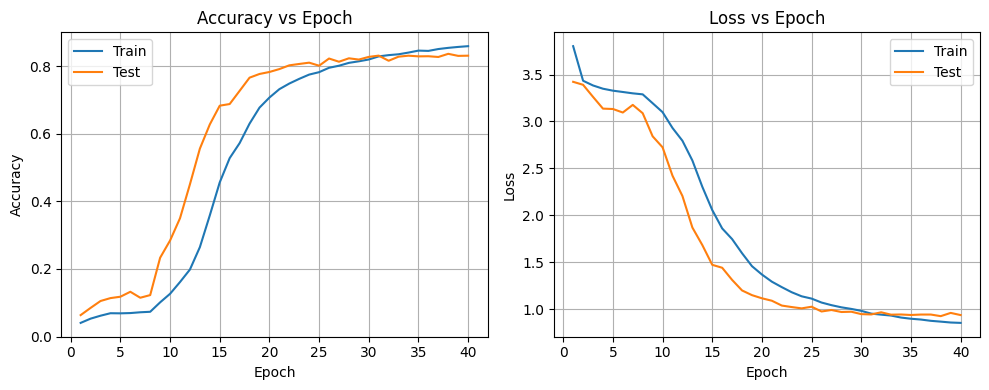

In [12]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 4))

# --- Accuracy ---
plt.subplot(1, 2, 1)
plt.plot(epochs, history["train_acc"], label="Train")
plt.plot(epochs, history["test_acc"],  label="Test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch")
plt.legend()
plt.grid(True)

# --- Loss ---
plt.subplot(1, 2, 2)
plt.plot(epochs, history["train_loss"], label="Train")
plt.plot(epochs, history["test_loss"],  label="Test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [13]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        logits = model(imgs)
        preds = logits.argmax(dim=1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)


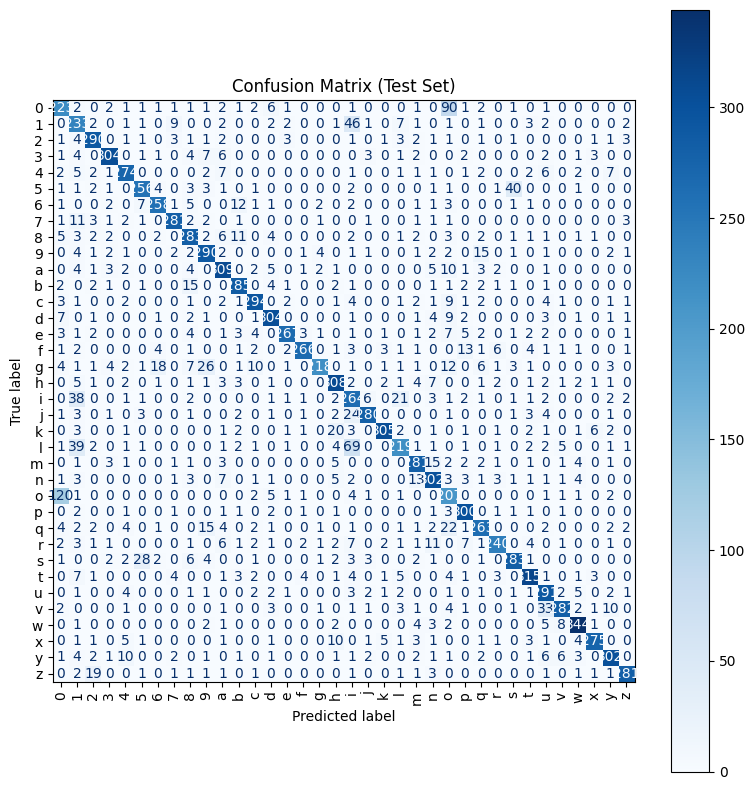

In [14]:
# class order is the same as train_dataset.class_names
class_names = train_dataset.class_names

cm = confusion_matrix(all_labels, all_preds)
fig, ax = plt.subplots(figsize=(8, 8))

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)
disp.plot(ax=ax, xticks_rotation=90, cmap="Blues", colorbar=True)

ax.set_title("Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()


Class '0': accuracy = 0.652
Class '1': accuracy = 0.735
Class '2': accuracy = 0.898
Class '3': accuracy = 0.889
Class '4': accuracy = 0.864
Class '5': accuracy = 0.803
Class '6': accuracy = 0.863
Class '7': accuracy = 0.898
Class '8': accuracy = 0.845
Class '9': accuracy = 0.863
Class 'a': accuracy = 0.868
Class 'b': accuracy = 0.882
Class 'c': accuracy = 0.880
Class 'd': accuracy = 0.894
Class 'e': accuracy = 0.850
Class 'f': accuracy = 0.842
Class 'g': accuracy = 0.673
Class 'h': accuracy = 0.873
Class 'i': accuracy = 0.748
Class 'j': accuracy = 0.851
Class 'k': accuracy = 0.862
Class 'l': accuracy = 0.615
Class 'm': accuracy = 0.865
Class 'n': accuracy = 0.846
Class 'o': accuracy = 0.595
Class 'p': accuracy = 0.943
Class 'q': accuracy = 0.790
Class 'r': accuracy = 0.803
Class 's': accuracy = 0.825
Class 't': accuracy = 0.873
Class 'u': accuracy = 0.895
Class 'v': accuracy = 0.810
Class 'w': accuracy = 0.922
Class 'x': accuracy = 0.870
Class 'y': accuracy = 0.860
Class 'z': accuracy 

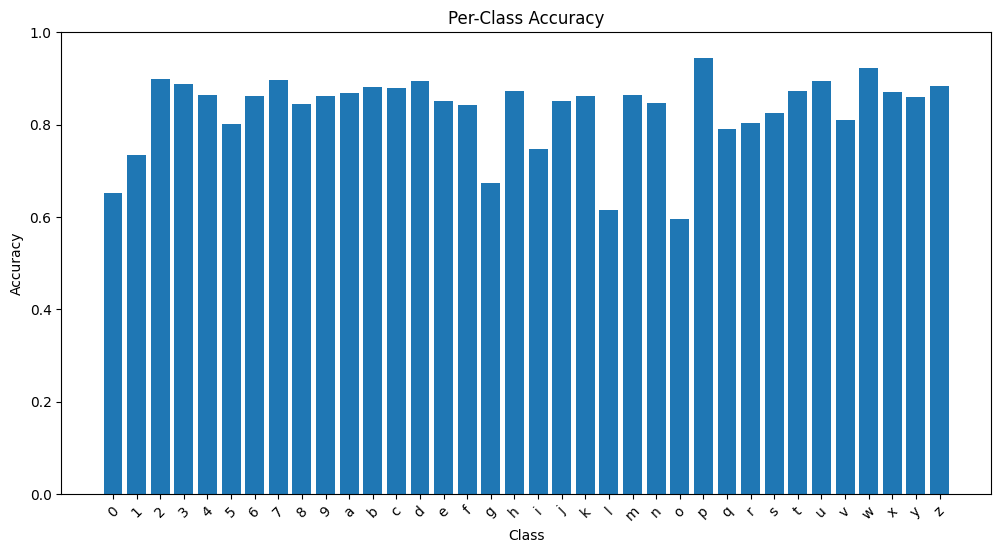

In [15]:
per_class_acc = cm.diagonal() / cm.sum(axis=1)

for cls, acc in zip(class_names, per_class_acc):
    print(f"Class {cls!r}: accuracy = {acc:.3f}")

# plot per-class accuracy
plt.figure(figsize=(12, 6))
plt.bar(class_names, per_class_acc)
plt.xlabel("Class")
plt.ylabel("Accuracy")
plt.title("Per-Class Accuracy")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()

In [17]:
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
)

def eval_metrics(model, data_loader, device, class_names=None):
    model.eval()
    all_targets = []
    all_preds   = []

    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device)
            y = y.to(device)

            logits = model(x)
            preds  = logits.argmax(dim=1)

            all_targets.append(y.cpu().numpy())
            all_preds.append(preds.cpu().numpy())

    y_true = np.concatenate(all_targets)
    y_pred = np.concatenate(all_preds)

    # --- overall recognition accuracy ---
    acc = accuracy_score(y_true, y_pred)

    # --- precision / recall (macro & micro) ---
    prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )
    prec_micro, rec_micro, f1_micro, _ = precision_recall_fscore_support(
        y_true, y_pred, average="micro", zero_division=0
    )

    print("=== Overall metrics on TEST set ===")
    print(f"Recognition Accuracy : {acc:.4f}")
    print(f"Precision (macro)    : {prec_macro:.4f}")
    print(f"Recall    (macro)    : {rec_macro:.4f}")
    print(f"F1-score  (macro)    : {f1_macro:.4f}")
    print(f"Precision (micro)    : {prec_micro:.4f}")
    print(f"Recall    (micro)    : {rec_micro:.4f}")
    print(f"F1-score  (micro)    : {f1_micro:.4f}")

    if class_names is not None:
        print("\n=== Per-class report ===")
        print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

    return {
        "accuracy": acc,
        "precision_macro": prec_macro,
        "recall_macro": rec_macro,
        "f1_macro": f1_macro,
        "precision_micro": prec_micro,
        "recall_micro": rec_micro,
        "f1_micro": f1_micro,
    }

CHARS = "0123456789abcdefghijklmnopqrstuvwxyz"

metrics = eval_metrics(model, test_loader, device, class_names=list(CHARS))

=== Overall metrics on TEST set ===
Recognition Accuracy : 0.8307
Precision (macro)    : 0.8410
Recall    (macro)    : 0.8313
F1-score  (macro)    : 0.8338
Precision (micro)    : 0.8307
Recall    (micro)    : 0.8307
F1-score  (micro)    : 0.8307

=== Per-class report ===
              precision    recall  f1-score   support

           0       0.57      0.65      0.61       342
           1       0.59      0.74      0.66       317
           2       0.86      0.90      0.88       323
           3       0.92      0.89      0.90       342
           4       0.86      0.86      0.86       317
           5       0.84      0.80      0.82       319
           6       0.88      0.86      0.87       299
           7       0.92      0.90      0.91       313
           8       0.80      0.84      0.82       335
           9       0.81      0.86      0.83       336
           a       0.83      0.87      0.85       356
           b       0.86      0.88      0.87       323
           c       0.89  

In [ ]:
# def evaluate_captcha_accuracy(model, captcha_loader, device):
#     """
#     Assumes captcha_loader returns:
#         images: (B, 1, H, W) captcha images
#         labels: list of strings such as ["ab3e9", "4h2xq", ...]
#     and your segmentation function returns a list of 64x64 character tiles.
#     """
#     model.eval()
#     total = 0
#     correct = 0

#     with torch.no_grad():
#         for img, label in captcha_loader:     # label is a list of strings
#             img = img.to(device)

#             # 1. Segment into character tiles
#             char_tiles = segment_into_chars(img[0].cpu().numpy())  
#             #          ^ your existing segmentation function

#             # If segmentation fails or wrong number of chars → wrong
#             if len(char_tiles) != len(label[0]):
#                 total += 1
#                 continue

#             # 2. Predict each character
#             preds = []
#             for tile in char_tiles:
#                 tile = torch.tensor(tile).unsqueeze(0).unsqueeze(0).float().to(device)
#                 logits = model(tile)
#                 pred_idx = logits.argmax(dim=1).item()
#                 preds.append(CHARS[pred_idx])

#             pred_str = "".join(preds)
#             true_str = label[0]

#             total += 1
#             if pred_str == true_str:
#                 correct += 1

#     captcha_accuracy = correct / total
#     print(f"Full CAPTCHA Accuracy: {captcha_accuracy:.4f} ({correct}/{total})")
#     return captcha_accuracy

# captcha_acc = evaluate_captcha_accuracy(model, captcha_test_loader, device)
